In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
%matplotlib inline

## Camera Model
Nikil Pancha

In [2]:
points = np.mgrid[-0.5:1:0.5, -0.5:1:0.5, -0.5:1:0.5].reshape(3, -1).T
colors = plt.cm.viridis(np.arange(len(points))/len(points))

In [3]:
cam1 = {
    'position': np.array([3, -3, 2]),
    'target': np.array([0, 0, 0]),
    'up': np.array([0, 0, 1]),
    'focal_length': 0.0600,
    'film_width': 0.0350,
    'film_height': 0.0350,
    'width': 256,
    'height': 256,
}

cam2 = {
    'position': np.array([2, 3, 3]),
    'target': np.array([0, 0, 0]),
    'up': np.array([0, 0, 1]),
    'focal_length': 0.0600,
    'film_width': 0.0350,
    'film_height': 0.0350,
    'width': 256,
    'height': 256,
}

In [4]:
def camera_coordinate_system(cam):
    zcam = np.array(cam['target']) - np.array(cam['position']);
    xcam = np.cross(zcam, cam['up']);

    ycam = np.cross(zcam, xcam);
    zcam = zcam / np.linalg.norm(zcam);
    xcam = xcam / np.linalg.norm(xcam);
    ycam = ycam / np.linalg.norm(ycam);
    origin = cam['position'];
    return [xcam, ycam, zcam, origin]

### Camera Model
Here, we want to project points from the 3d world coordinates to a 2d image that would be what the camera would see. There are three main steps here. First, we need to translate the world coordinates of different objects into camera coordinates. This alone is a two-step process: first, we translate the coordinates so the camera is centered at the origin, and then we apply a rotation to bring the world coordinates into camera coordinates. Then, we need to determine where the image would be on the "film." Finally, we need to convert the film coordinates into pixel coordinates. These steps can be represented by 4 affine transformations, so their composition can be represented by a single matrix, which is the camera matrix.

#### Extrinsic Matrix
First, let us have a point 
$$
a = \begin{pmatrix}U \\ V \\ W \\ 1\end{pmatrix}
$$
where $(U,V,W)$ is the position in world coordinates, and the 1 is added on so that the affine transformations can be represented as matrices. If our camera is located at the point $(c_x, c_y, c_z)$ in world coordinates, then we want to first perform a transformations of $-c_x, -c_y, -c_z$ in the $x$, $y$, and $z$ coordinates respectively. This step can be represented by a matrix as follows:
$$
S = 
\begin{pmatrix}
1 & 0 & 0 & -c_x\\
0 & 1 & 0 & -c_y\\
0 & 0 & 1 & -c_z
\end{pmatrix}
$$
Next, we want to translate the axes in world coordinates to be axes in camera coordinates. We can construct the camera axes (in world coordinates) by taking cross products, so then we will get three vectors, $a_x, a_y, a_z$, which are the axes of the camera. These must be normalized, because this step is a rotation, which is a rigid transformation. If they were not unit vectors, then this would be scaling the size of objects in different directions, which is the purpose of the intrinsic matrix, not the extrinsic one.

We want a transformation $R$ such that if we apply it to $a_x$, we get $(1\;0\;0)^T$, if we apply it to $a_y$, we get $(0\;1\;0)^T$, and if we apply it to $a_z$, we get $(0\;0\;1)^T$. Because $a_x, a_y, a_z$ are all orthonormal, if let $P=(a_x\;a_y\;a_z)$, then we want $RP = I$ , so $R = I P^-1 = P^T$.

Composing the rotation and translation matrices (tranlation first), we get the extrinsic matrix.


In [5]:
def extrinsic_matrix(cam):
    xcam, ycam, zcam, origin = camera_coordinate_system(cam)
    R = np.vstack((xcam, ycam, zcam)).T
    M = np.vstack((R, -origin @ R))
    return M

#### Intrinsic Matrix
Here, we once again have two steps. First, we want to scale the image appropriately. This is based on the focal length of the lens and the width of the sensor/film. Let the focal length be $f$, the film width be $s_x$ and the film height be $s_y$. We can also say $o_x$ and $o_y$ are the offsets of the center in film coordinates from the center in pixel coordinates.

If our point is $(X\;Y\;Z)^T$ in camera coordinates, the first step is to determine what it will become in film coordinates. This can just be thought of a problem like similar triangles: if $u,v$ is the position in pixel coordinates (up to a constant offset), then we have $u=f \frac{X}{s_x Z}$ and $v=f \frac{Y}{s_y Z}$. The fraction $f/Z$ corresponds to the ratio of the distance of the object to the distance of the "film." This can be seen by observing that if we have a line in the image plane, the triangle formed by the endpoints of that line and the camera aperture should be similar to the triangle in the film coordinates (and the ratio of distances is $f/Z$). The film height and film width are only used to compensate for the fact that if we have film that is not square, the image would be distorted.

We can then come up with a matrix to project our camera coordinate point into film coordinates:
$$
    P = \begin{pmatrix}
    f & 0 & 0\\
    0 & f & 0\\
    0 & 0 & 1\\
    \end{pmatrix}
$$
This resizes the points so that only an affine transform and then division by $Z$ is required.

The final matrix is an affine transformation to scale our points to pixel coordinates, and remove warping from the sensor size.
$$
    A = \begin{pmatrix}
    1/s_x & 0 & o_y\\
    0 & 1/s_y & o_x\\
    0 & 0 & 1\\
    \end{pmatrix}
$$
Then, we can take 
$$
    \begin{pmatrix}
    u'\\
    v'\\
    z'\\
    \end{pmatrix} = A P \begin{pmatrix}
    X\\
    Y\\
    Z\\
    \end{pmatrix}
$$

Finally, we must divide by $z'$ (or equivalently $Z$), which scales the coordinates back.

In [6]:
def intrinsic_matrix(cam):
    cx = (cam['width']+1) * 0.5;
    cy = (cam['height']+1) * 0.5;

    fx = cam['focal_length'] * cam['width'] / cam['film_width'];
    fy = cam['focal_length'] * cam['height'] / cam['film_height'];
    K = np.array([[fx, 0, 0], [0, fy, 0], [cx, cy, 1]])
    return K
def camera_matrix(cam):
    return extrinsic_matrix(cam) @ intrinsic_matrix(cam)

#### Drawing an image
From the knowledge of how to construct the intrinsic and extrinsic matrices, we can compose them. We will apply the extrinsic matrix first to get points in camera coordinates, and then apply the intrinsic matrix, and scale by $z'$.

In [7]:
def world_to_xy(cam, points):
    P = camera_matrix(cam)
    points = np.hstack((points, np.ones((len(points), 1)))) @ P
    x = points[:, 0] / points[:, 2]
    y = points[:, 1] / points[:, 2]
    return np.vstack((x,y)).T
def draw_image(centers, colors, R, imshape=(256, 256)):
    im = np.ones((*imshape, 4))
    for ix, (color, center) in enumerate(zip(colors, centers)):
        for x in range(-R, R+1):
            for y in range(-R, R+1):
                if (x**2+y**2) <= R**2:
                    im[int(center[0] + x), int(center[1] + y)] = color
    return im

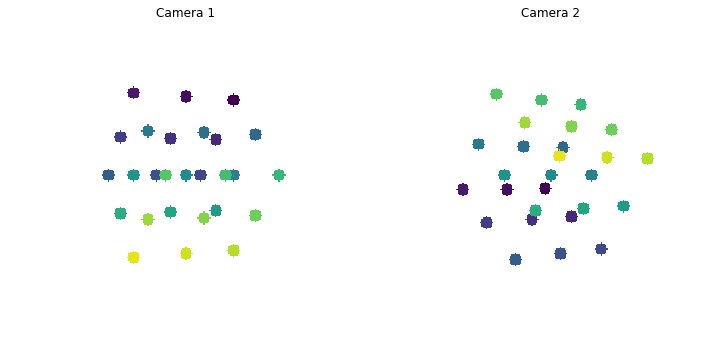

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Camera 1')
plt.imshow(draw_image(world_to_xy(cam1, points), colors, 5))
plt.axis('off');
plt.subplot(122)
plt.title('Camera 2')
plt.imshow(draw_image(world_to_xy(cam2, points), colors, 5))
plt.axis('off');